# Imports

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import os
import sys
import functools
import copy
import tempfile
import subprocess
import shutil

import boda
import tqdm
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn

# Cloud helpers, may have removed them from use though

In [4]:
def cloud_load(func):
    @functools.wraps(func)
    def wrapper_decorator(*args, **kwargs):
        print(f'loading file from {args[0]}', file=sys.stderr)
        if 'gs://' == args[0][:5]:
            args = copy.deepcopy(list(args))
            with tempfile.TemporaryDirectory() as tempdir:
                temp_loc = os.path.join(tempdir, os.path.basename(args[0]))
                subprocess.check_call(['gsutil','cp',args[0], temp_loc])
                args[0] = temp_loc
                value = func(*args, **kwargs)
        else:
            value = func(*args, **kwargs)
        print('Success', file=sys.stderr)
        return value
    return wrapper_decorator

@cloud_load
def load_fasta(fasta_fn):
    data = {'id': [], 'sequence': []}
    with open(fasta_fn, 'r') as f:
        for i, line in enumerate(f):
            if i % 2 == 0:
                data['id'].append(line.rstrip())
            else:
                data['sequence'].append(line.rstrip())
    return pd.DataFrame(data)

# Collect MPRA by cell type

In [6]:
K562 = pd.read_table('OL46_K562_20220720.out', sep='\t', header=0, index_col='ID')
HepG2= pd.read_table('OL46_HepG2_20220720.out', sep='\t', header=0, index_col='ID')
SKNSH= pd.read_table('OL46_SKNSH_20220720.out', sep='\t', header=0, index_col='ID')

In [7]:
print(f"K526: {K562.shape}")
print(f"HepG2: {HepG2.shape}")
print(f"SKNSH: {SKNSH.shape}")

K562['cell_type'] = 'K562'
HepG2['cell_type'] = 'HepG2'
SKNSH['cell_type'] = 'SKNSH'


K526: (120057, 21)
HepG2: (120057, 21)
SKNSH: (120057, 21)


# Merge data over cells

In [8]:
merged = pd.concat([K562.loc[:,('project','log2FoldChange')], HepG2.loc[:,('log2FoldChange')], SKNSH.loc[:,('log2FoldChange')]], axis=1)
merged.columns = ['project', 'K562_signal', 'HepG2_signal', 'SKNSH_signal']

merged['K562_deltamax'] = merged['K562_signal'] - merged.loc[:, ('HepG2_signal', 'SKNSH_signal')].max(axis=1)
merged['HepG2_deltamax'] = merged['HepG2_signal'] - merged.loc[:, ('K562_signal', 'SKNSH_signal')].max(axis=1)
merged['SKNSH_deltamax'] = merged['SKNSH_signal'] - merged.loc[:, ('K562_signal', 'HepG2_signal')].max(axis=1)

In [9]:
K562['deltamax'] = merged['K562_deltamax']
HepG2['deltamax'] = merged['HepG2_deltamax']
SKNSH['deltamax'] = merged['SKNSH_deltamax']

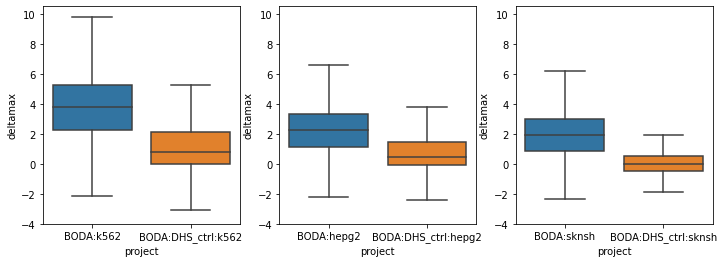

In [10]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

sns.boxplot(data=K562.loc[ (K562['project'] == 'BODA:k562') | (K562['project'] == 'BODA:DHS_ctrl:k562') ], x='project', y='deltamax', showfliers=False, ax=ax[0])
sns.boxplot(data=HepG2.loc[ (HepG2['project'] == 'BODA:hepg2') | (HepG2['project'] == 'BODA:DHS_ctrl:hepg2') ], x='project', y='deltamax', showfliers=False, ax=ax[1])
sns.boxplot(data=SKNSH.loc[ (SKNSH['project'] == 'BODA:sknsh') | (SKNSH['project'] == 'BODA:DHS_ctrl:sknsh') ], x='project', y='deltamax', showfliers=False, ax=ax[2])

for axis in ax:
    axis.set_ylim([-4, 10.5])  

plt.show()

In [11]:
def entropy(X):
    p_c = F.softmax(torch.tensor(X, dtype=torch.float64), dim=1).numpy()
    shannon = np.sum(- p_c * np.log(p_c), axis=1)
    return shannon / np.log(X.shape[1])


In [12]:
merged['entropy'] = entropy(
    torch.tensor( merged.loc[:,('K562_signal', 'HepG2_signal', 'SKNSH_signal')].values )
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [13]:
'''
array(['MPRA:ctrl_pos', 'MPRA:ctrl_neg', 'BODA:k562', 'BODA:hepg2',
       'BODA:sknsh', 'BODA:genomic', 'BODA:DHS_ctrl:hepg2',
       'BODA:DHS_ctrl:k562', 'BODA:DHS_ctrl:sknsh',
       'MPRA:nadav_negCtrl-shuf', 'MPRA:ORF_negCtrl'], dtype=object)
'''


"\narray(['MPRA:ctrl_pos', 'MPRA:ctrl_neg', 'BODA:k562', 'BODA:hepg2',\n       'BODA:sknsh', 'BODA:genomic', 'BODA:DHS_ctrl:hepg2',\n       'BODA:DHS_ctrl:k562', 'BODA:DHS_ctrl:sknsh',\n       'MPRA:nadav_negCtrl-shuf', 'MPRA:ORF_negCtrl'], dtype=object)\n"

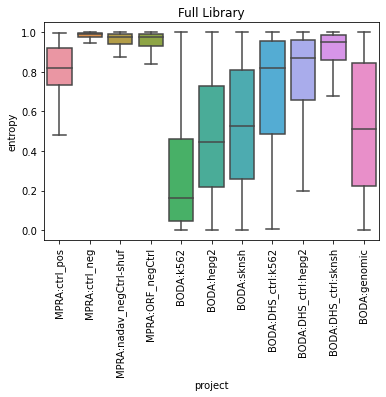

In [14]:
sns.boxplot(
    data=merged, x='project', y='entropy', showfliers=False, 
    order=[
        'MPRA:ctrl_pos', 'MPRA:ctrl_neg', 'MPRA:nadav_negCtrl-shuf', 'MPRA:ORF_negCtrl', 
        'BODA:k562', 'BODA:hepg2', 'BODA:sknsh', 'BODA:DHS_ctrl:k562', 'BODA:DHS_ctrl:hepg2', 'BODA:DHS_ctrl:sknsh',
        'BODA:genomic'
    ]
)
plt.title("Full Library")
plt.xticks(rotation=90)

plt.savefig('entropy_distribution_by_project__full_library.pdf')
plt.show()

In [23]:
merged

project  K562_signal  HepG2_signal  SKNSH_signal  \
ID                                                                             
1:10437778:C:T:R:wC   MPRA:ctrl_pos     2.966183      4.557974      3.043528   
1:10451799:C:T:R:wC   MPRA:ctrl_neg     0.095328      0.066151     -0.588737   
1:110198727:C:G:R:wC  MPRA:ctrl_pos     6.666020      5.082079      6.739022   
1:110881742:NA:NA     MPRA:ctrl_pos     4.896945      3.268988      5.034290   
1:111838694:C:T:R:wC  MPRA:ctrl_pos     5.905227      5.057442      6.709777   
...                             ...          ...           ...           ...   
X:24893812:NA:NA      MPRA:ctrl_neg     0.120669     -0.011163      0.354030   
X:39110157:NA:NA      MPRA:ctrl_neg     0.343890      0.153843      0.174570   
X:49154578:NA:NA      MPRA:ctrl_neg     0.129982      0.135645      0.252243   
X:64815540:NA:NA      MPRA:ctrl_pos     4.508452      3.189764      5.559535   
X:69674065:NA:NA      MPRA:ctrl_neg     0.377419      0.543702      0.316820   

                      K562_deltamax  HepG2_deltamax  SKNSH_deltamax   entropy  
ID                                                                             
1:10437778:C:T:R:wC       -1.591791        1.514446       -1.514446  0.741592  
1:10451799:C:T:R:wC        0.029177       -0.029177       -0.684064  0.962507  
1:110198727:C:G:R:wC      -0.073002       -1.656943        0.073002  0.848901  
1:110881742:NA:NA         -0.137345       -1.765302        0.137345  0.838163  
1:111838694:C:T:R:wC      -0.804549       -1.652335        0.804549  0.825380  
...                             ...             ...             ...       ...  
X:24893812:NA:NA          -0.233361       -0.365192        0.233361  0.989378  
X:39110157:NA:NA           0.169320       -0.190046       -0.169320  0.996585  
X:49154578:NA:NA          -0.122261       -0.116598        0.116598  0.998519  
X:64815540:NA:NA          -1.051082       -2.369771        1.051082  0.705365  
X:69674065:NA:NA          -0.166282        0.166282       -0.226881  0.995694  

[120057 rows x 8 columns]

# Read MPRA library data and make predictions

In [15]:
new_seqs = pd.read_table('boda_round_1_controls_20211215.seq.oligo.collapse.seq', sep='\t', usecols=[0,8], header=None, names=['id','sequence'])
new_seqs = new_seqs.loc[ [ True if len(x) == 200 else False for x in new_seqs['sequence'] ] ]
new_seqs

id  \
0                               10:110548543:C:T:R:wC   
1                                  10:114578220:NA:NA   
2                                  10:115676701:NA:NA   
3                                  10:121275046:NA:NA   
4                                  10:124924855:NA:NA   
...                                               ...   
119995    control_DHS_S_9944::chr12:98644710-98644910   
119996  control_DHS_S_9954::chr12:100200367-100200567   
119997  control_DHS_S_9972::chr12:102120782-102120918   
119998  control_DHS_S_9974::chr12:102534950-102535150   
119999  control_DHS_S_9975::chr12:102567087-102567287   

                                                 sequence  
0       AAGGTAAGCTGCAAATTCGTCTAAGAGCTGCTTAAAAGCCAAAGCA...  
1       CAGCATCCAGAGATTATCAACCCATAGAAGAAGGGAGGGGAAAAAA...  
2       AATCTACAAGTTCATATATTGGTATTTCTAGACATAGTCTAGTTCT...  
3       TTTCAGTAAATTCTTCCAGGCCTGGAATTAATGTAGGTTTTCAAAT...  
4       CTGACGTATTTCCCCTTCTGTCCCCTAGTAAGCCCAGTTGCTGTAT...  
...                                                   ...  
119995  CCCTAGGACGACAAGCCCAGGGCAGCTTCTTCACCAGGGGGAGCAG...  
119996  TTTTTGGATGAGAAAGACTCACTCAGCTTCGTCCTGAAGAGCAAGT...  
119997  TGTTTCACTAACGTCTCATTCTGTGAGGTAGGAATTCCCTTCCTGG...  
119998  CTTAGTTAATTCATCCCACATGTTTCCTCTGCTGACTGGTGAAAGA...  
119999  ATTAGAACTTGTAACCCGGGAAGGTCAGGGTCAATGATTTCAAGTC...  

[119997 rows x 2 columns]

In [16]:
seq_tensor = torch.stack([ boda.common.utils.dna2tensor( x ) for x in new_seqs['sequence'] ], dim=0)

In [17]:
left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)
left_flank.shape

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)
right_flank.shape

flank_builder = boda.data.FlankBuilder(
    left_flank=left_flank,
    right_flank=right_flank,
)


AttributeError: module 'boda.data' has no attribute 'FlankBuilder'

In [17]:
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'

if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

unpack_artifact(hpo_rec)

model_dir = './artifacts'

my_model = model_fn(model_dir)
my_model.cuda()
my_model.eval()

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [18]:
bsz = 1024

results = []

with torch.no_grad():

    for i in tqdm.tqdm( range((seq_tensor.shape[0] // bsz)+int( (seq_tensor.shape[0] % bsz) > 0 )) ):
        start = i * bsz
        end   = (i+1) * bsz
        batch_fw = flank_builder( seq_tensor[start:end] )
        batch_rc = flank_builder( torch.flip( seq_tensor[start:end], dims=[-2,-1] ) )
        pred_fw = my_model( batch_fw.float().cuda() ).cpu()
        pred_rc = my_model( batch_rc.float().cuda() ).cpu()
        
        results.append( (pred_fw+pred_rc).div(2.).numpy() )
    
results = np.concatenate( results, axis=0 )


100%|██████████| 118/118 [00:04<00:00, 26.41it/s]


In [19]:
new_seqs[['K562_pred','HepG2_pred','SKNSH_pred']] = results

In [20]:
new_seqs = new_seqs.set_index('id')

In [21]:
easy_check = pd.concat([new_seqs, merged], join='inner', axis=1)

# Plot bulk performance

In [22]:
# [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


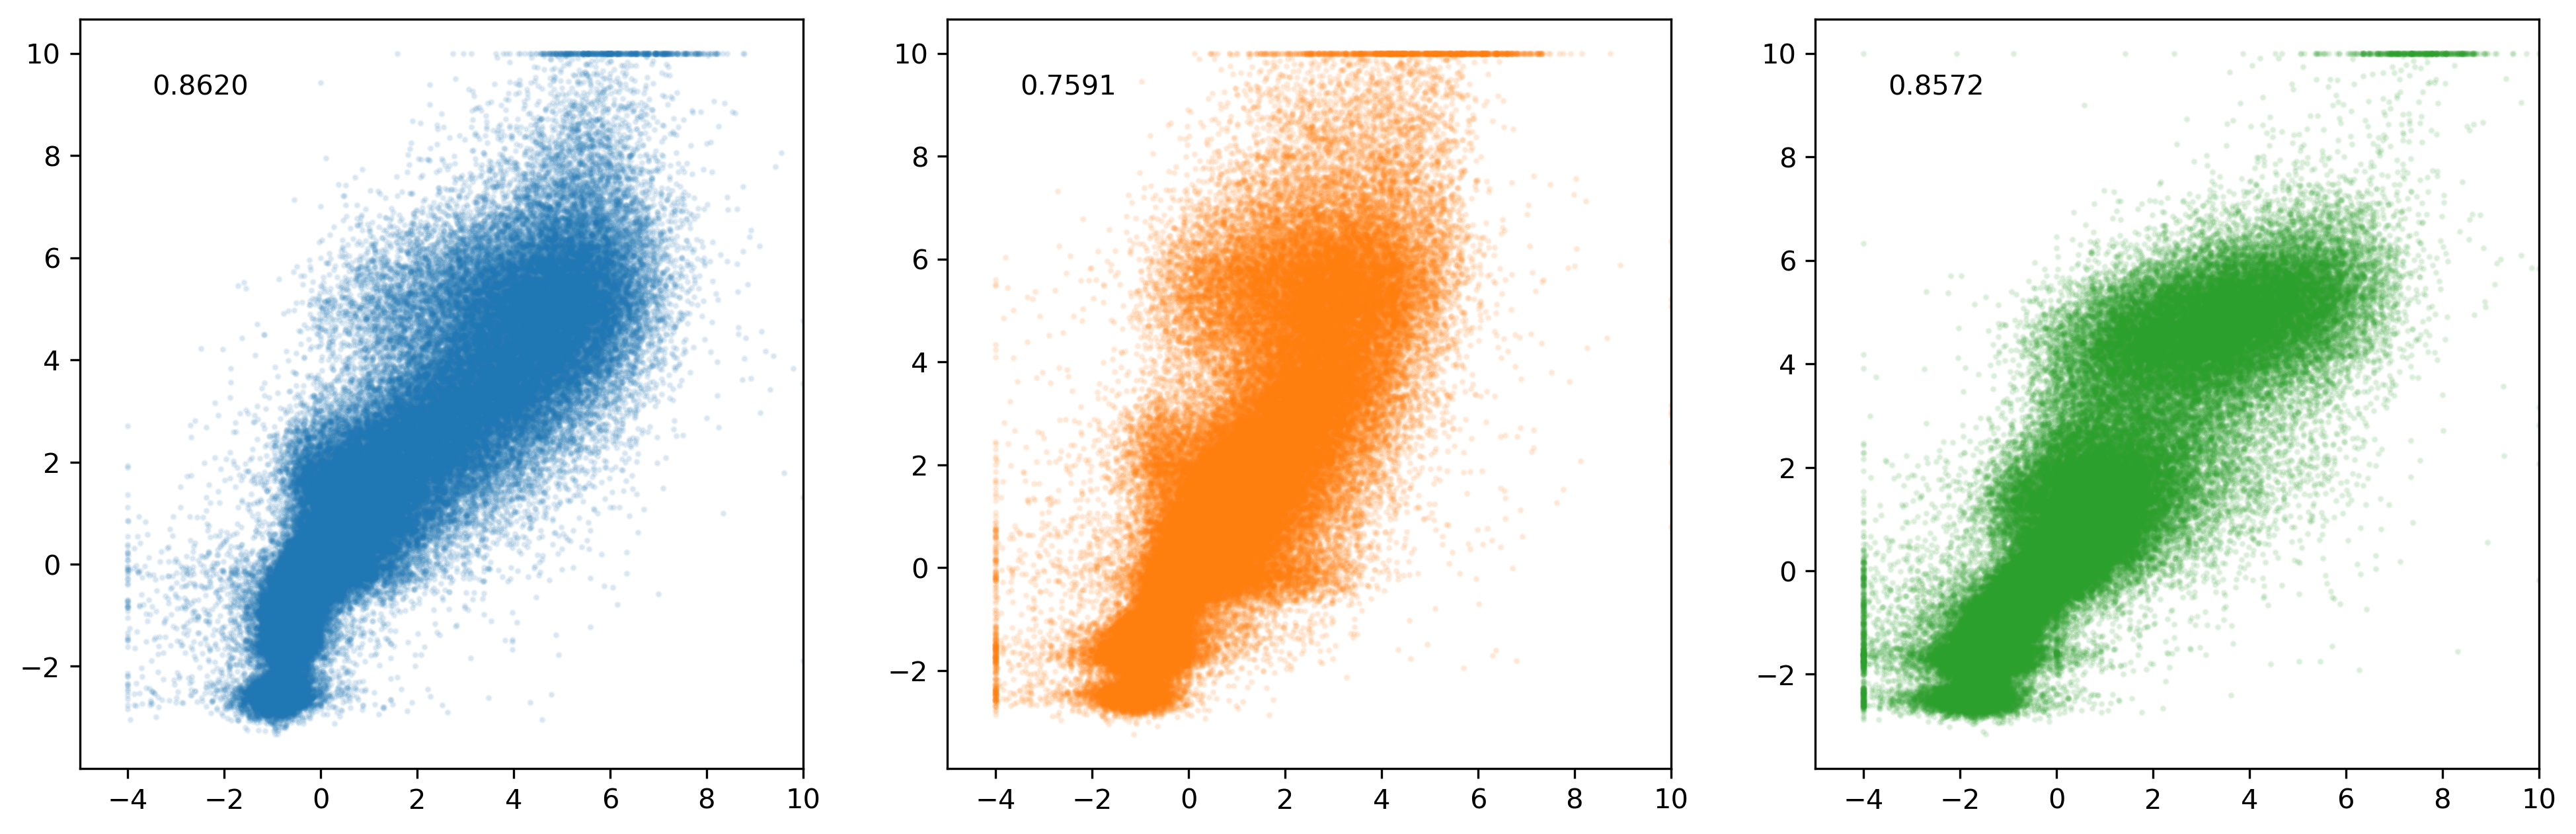

In [23]:
easy_check = easy_check.loc[ easy_check.isna().sum(axis=1) == 0 ]
easy_check['entropy_pred'] = entropy(
    torch.tensor( easy_check.loc[:,('K562_pred', 'HepG2_pred', 'SKNSH_pred')].values )
)

K562_corr = sp.stats.pearsonr(x=easy_check['K562_signal'], y=easy_check['K562_pred'])
HepG2_corr = sp.stats.pearsonr(x=easy_check['HepG2_signal'], y=easy_check['HepG2_pred'])
SKNSH_corr = sp.stats.pearsonr(x=easy_check['SKNSH_signal'], y=easy_check['SKNSH_pred'])

fig, axes = plt.subplots(1, 3, figsize=(16,5), dpi=300)
axes[0].scatter(x=easy_check['K562_signal'].clip(-4,10), y=easy_check['K562_pred'].clip(-4,10), s=2, color='#1f77b4', alpha=0.1, rasterized=True)
axes[0].text(x=0.1,y=0.9,s='{:.4f}'.format(K562_corr[0]), transform=axes[0].transAxes)
axes[0].set_xlim(-5,10)

axes[1].scatter(x=easy_check['HepG2_signal'].clip(-4,10), y=easy_check['HepG2_pred'].clip(-4,10), s=2, color='#ff7f0e', alpha=0.1, rasterized=True)
axes[1].text(x=0.1,y=0.9,s='{:.4f}'.format(HepG2_corr[0]), transform=axes[1].transAxes)
axes[1].set_xlim(-5,10)

axes[2].scatter(x=easy_check['SKNSH_signal'].clip(-4,10), y=easy_check['SKNSH_pred'].clip(-4,10), s=2, color='#2ca02c', alpha=0.1, rasterized=True)
axes[2].text(x=0.1,y=0.9,s='{:.4f}'.format(SKNSH_corr[0]), transform=axes[2].transAxes)
axes[2].set_xlim(-5,10)

plt.savefig('Malinois_synthetic_activity_performance.pdf')

plt.show()

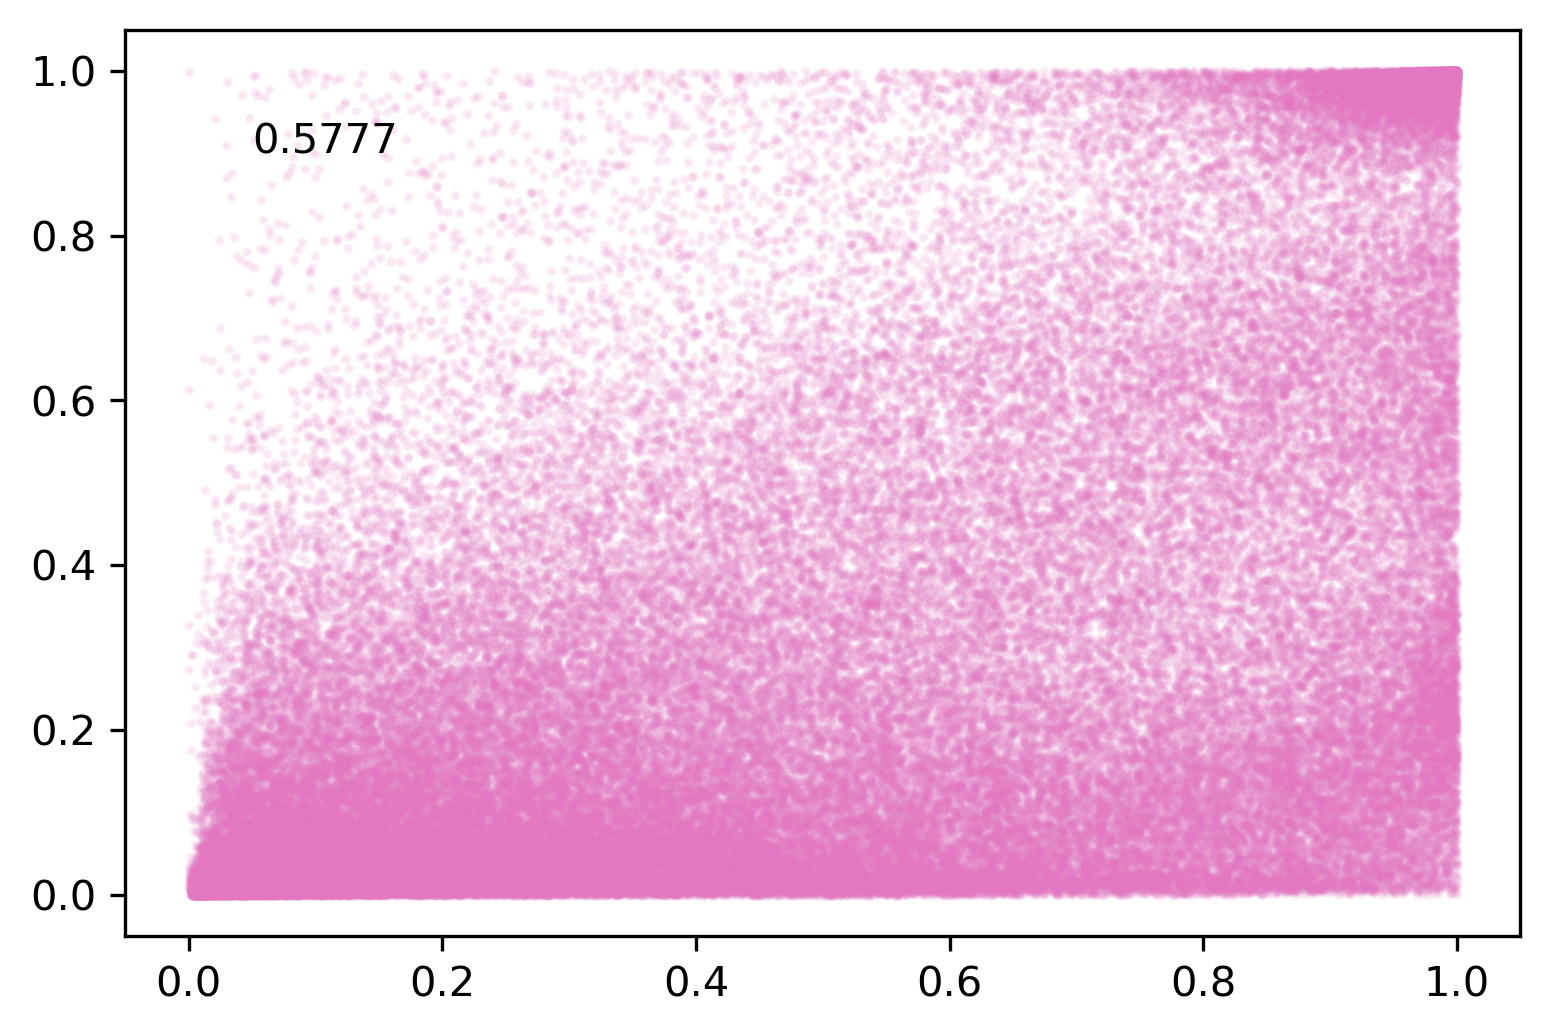

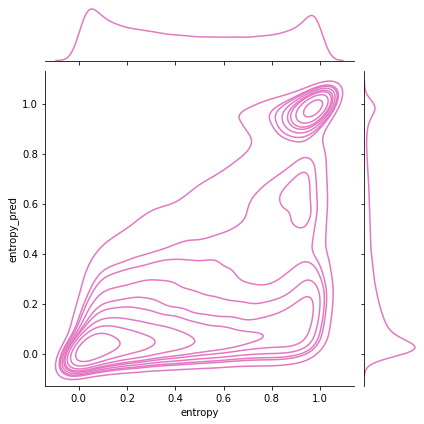

In [24]:
entropy_corr = sp.stats.pearsonr(x=easy_check['entropy'], y=easy_check['entropy_pred'])
plt.figure(dpi=300)
plt.scatter(x=easy_check['entropy'], y=easy_check['entropy_pred'], color=u'#e377c2', s=2, alpha=0.1, rasterized=True)
plt.text(x=0.05,y=0.9,s='{:.4f}'.format(entropy_corr[0]))

plt.savefig('Malinois_synthetic_entropy_performance.pdf')

plt.show()
g = sns.jointplot(x=easy_check['entropy'], y=easy_check['entropy_pred'], kind='kde', color=u'#e377c2')
plt.savefig('Malinois_synthetic_entropy_performance_jp.pdf')
plt.show()

In [25]:
easy_check

sequence  \
10:110548543:C:T:R:wC                          AAGGTAAGCTGCAAATTCGTCTAAGAGCTGCTTAAAAGCCAAAGCA...   
10:114578220:NA:NA                             CAGCATCCAGAGATTATCAACCCATAGAAGAAGGGAGGGGAAAAAA...   
10:115676701:NA:NA                             AATCTACAAGTTCATATATTGGTATTTCTAGACATAGTCTAGTTCT...   
10:121275046:NA:NA                             TTTCAGTAAATTCTTCCAGGCCTGGAATTAATGTAGGTTTTCAAAT...   
10:124924855:NA:NA                             CTGACGTATTTCCCCTTCTGTCCCCTAGTAAGCCCAGTTGCTGTAT...   
...                                                                                          ...   
control_DHS_S_9944::chr12:98644710-98644910    CCCTAGGACGACAAGCCCAGGGCAGCTTCTTCACCAGGGGGAGCAG...   
control_DHS_S_9954::chr12:100200367-100200567  TTTTTGGATGAGAAAGACTCACTCAGCTTCGTCCTGAAGAGCAAGT...   
control_DHS_S_9972::chr12:102120782-102120918  TGTTTCACTAACGTCTCATTCTGTGAGGTAGGAATTCCCTTCCTGG...   
control_DHS_S_9974::chr12:102534950-102535150  CTTAGTTAATTCATCCCACATGTTTCCTCTGCTGACTGGTGAAAGA...   
control_DHS_S_9975::chr12:102567087-102567287  ATTAGAACTTGTAACCCGGGAAGGTCAGGGTCAATGATTTCAAGTC...   

                                               K562_pred  HepG2_pred  \
10:110548543:C:T:R:wC                           0.154129   -0.241808   
10:114578220:NA:NA                              0.582514   -0.006553   
10:115676701:NA:NA                              0.082926   -0.089010   
10:121275046:NA:NA                              0.211630    0.427375   
10:124924855:NA:NA                              1.637362    1.588518   
...                                                  ...         ...   
control_DHS_S_9944::chr12:98644710-98644910     2.895285    2.070613   
control_DHS_S_9954::chr12:100200367-100200567   1.137272    0.723077   
control_DHS_S_9972::chr12:102120782-102120918   0.584232    0.451866   
control_DHS_S_9974::chr12:102534950-102535150   0.544845    0.655460   
control_DHS_S_9975::chr12:102567087-102567287  -0.013060    0.460101   

                                               SKNSH_pred  \
10:110548543:C:T:R:wC                           -0.219508   
10:114578220:NA:NA                               0.506015   
10:115676701:NA:NA                              -0.080472   
10:121275046:NA:NA                               0.460105   
10:124924855:NA:NA                               1.186892   
...                                                   ...   
control_DHS_S_9944::chr12:98644710-98644910      3.125463   
control_DHS_S_9954::chr12:100200367-100200567    0.606193   
control_DHS_S_9972::chr12:102120782-102120918    0.032808   
control_DHS_S_9974::chr12:102534950-102535150    0.169294   
control_DHS_S_9975::chr12:102567087-102567287    0.620278   

                                                           project  \
10:110548543:C:T:R:wC                                MPRA:ctrl_neg   
10:114578220:NA:NA                                   MPRA:ctrl_neg   
10:115676701:NA:NA                                   MPRA:ctrl_neg   
10:121275046:NA:NA                                   MPRA:ctrl_neg   
10:124924855:NA:NA                                   MPRA:ctrl_neg   
...                                                            ...   
control_DHS_S_9944::chr12:98644710-98644910    BODA:DHS_ctrl:sknsh   
control_DHS_S_9954::chr12:100200367-100200567  BODA:DHS_ctrl:sknsh   
control_DHS_S_9972::chr12:102120782-102120918  BODA:DHS_ctrl:sknsh   
control_DHS_S_9974::chr12:102534950-102535150  BODA:DHS_ctrl:sknsh   
control_DHS_S_9975::chr12:102567087-102567287  BODA:DHS_ctrl:sknsh   

                                               K562_signal  HepG2_signal  \
10:110548543:C:T:R:wC                             0.094227     -0.078726   
10:114578220:NA:NA                                0.257153      0.133150   
10:115676701:NA:NA                                0.191530      0.191865   
10:121275046:NA:NA                                0.164982      0.367464   
10:124924855:NA:NA                                0.580530      0.42